In [4]:
import numpy as np
import pandas as pd
import time
from joblib import Parallel, delayed

In [4]:
sort_train.Z.unique()

array([     0.        ,   1293.        ,   2586.        ,   2880.45703125,
         3879.        ,   4151.99609375,   5172.        ,   6465.        ,
         7758.        ,   9051.        ,  10344.        ,  11637.        ,
        11794.10742188,  12930.        ,  14223.        ,  15516.        ,
        16809.        ,  16884.28710938,  18102.        ,  18153.56445312,
        19395.        ,  20688.        ,  21981.        ,  23249.41015625,
        23251.03320312,  23251.6484375 ,  23274.        ,  24567.        ,
        25797.32421875,  25860.        ,  27153.        ,  28446.        ,
        29739.        ,  31032.        ,  32325.        ,  33435.015625  ,
        33618.        ,  34911.        ,  35980.05078125,  35982.87109375,
        36204.        ,  37252.6875    ,  37497.        ,  38790.        ,
        40083.        ,  41376.        ,  42669.        ,  43962.        ,
        45255.        ,  46548.        ,  47841.        ,  49134.        ,
        50427.        ,  

In [ ]:
from joblib import Parallel, delayed
import time

n = 300
dZ = 1293

back = pd.read_hdf('/data/viktor/data_4/hdf5-0/open0.h5')

#TX	TY	X	Y	Z		signal	
# 0 1.  2.  3.  4          5 
back = back.drop('event_id', axis=1)
back = back.drop('data_ind', axis=1)
back_array = np.array(back)
back_array_next = np.array([back_array[:, 0]*dZ + back_array[:, 2],
                            back_array[:, 1]*dZ + back_array[:, 3],
                            ((back_array[:, 4]//1293) + 1) * 1293]).T

start_time = time.time()

def my_function(i):
    global back_array
    global back_array_next
    neighbors = back_array[(back_array[:, 4] < back_array_next[i, 2] + 1200) & (back_array_next[i, 2] <= back_array[:, 4])]
    neighbors = neighbors[(neighbors[:, 2] < back_array_next[i, 0] + n) & (back_array_next[i, 0] - n < neighbors[:, 2])]
    neighbors = neighbors[(neighbors[:, 3] < back_array_next[i, 1] + n) & (back_array_next[i, 1] - n < neighbors[:, 3])]

    dist = np.sqrt((neighbors[:, 2] - back_array[i, 2]) ** 2 + (neighbors[:, 3] - back_array[i, 3]) ** 2 + (neighbors[:, 4] - back_array[i, 4]) ** 2)
    best_neighbors = neighbors[((abs(neighbors[:, 0] - back_array[i, 0]) + abs(neighbors[:, 1] - back_array[i, 1]) + 1e-3) / (1 + dist)).argsort()[:3]]
    if best_neighbors.shape[0] == 0:
        local_rows = []
        return
    if i%10000 == 0:
        print(i)
        print("--- %s seconds ---" % (time.time() - start_time))
    local_rows = []
    for neighbor in best_neighbors:
        local_rows.append(np.concatenate([back_array[i, :], neighbor]))
    return local_rows

        
        
sessions_train_0 = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in range(back.shape[0]))
sessions_train_0 = [x for x in sessions_train_0 if x is not None]
train_0 = np.concatenate(sessions_train_0)

0
--- 0.16128778457641602 seconds ---
10000
--- 1.6387581825256348 seconds ---
30000
--- 5.018329620361328 seconds ---
50000
--- 7.686347961425781 seconds ---
60000
--- 9.274935483932495 seconds ---
70000
--- 10.732155799865723 seconds ---
80000
--- 12.35422420501709 seconds ---
120000
--- 18.386609315872192 seconds ---
140000
--- 21.231293201446533 seconds ---
160000
--- 23.99138331413269 seconds ---
180000
--- 27.283209562301636 seconds ---
190000
--- 28.525105714797974 seconds ---
200000
--- 30.2147798538208 seconds ---
210000
--- 31.878807544708252 seconds ---
240000
--- 36.33445072174072 seconds ---
250000
--- 37.71473550796509 seconds ---
260000
--- 39.268543004989624 seconds ---
270000
--- 41.00176239013672 seconds ---
300000
--- 45.552228927612305 seconds ---
310000
--- 46.804438829422 seconds ---
320000
--- 48.30268216133118 seconds ---
330000
--- 50.13842272758484 seconds ---
350000
--- 53.00621032714844 seconds ---
370000
--- 55.82520771026611 seconds ---
390000
--- 58.56573

In [92]:
train_0
csv_y_pred = pd.DataFrame(data=train_0, columns=['TX1','TY1', 'X1', 'Y1','Z1', 'signal1', 'TX2','TY2', 'X2', 'Y2','Z2', 'signal2'])
csv_y_pred['dZ'] = csv_y_pred.Z1 - csv_y_pred.Z2


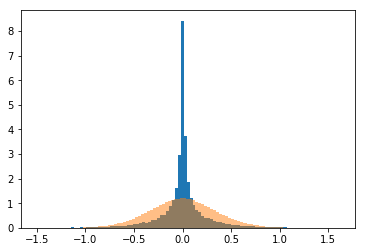

In [104]:
import matplotlib.pyplot as plt
plt.hist((csv_y_pred['TX2'] - csv_y_pred['TX1'])[csv_y_pred['signal1'] == 1.], bins=100, normed=True);
plt.hist((csv_y_pred['TX2'] - csv_y_pred['TX1'])[csv_y_pred['signal1'] == 0.], bins=100, normed=True, alpha=0.5);
plt.show()

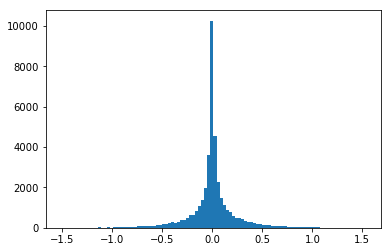

In [105]:
plt.hist((csv_y_pred['TX2'] - csv_y_pred['TX1'])[csv_y_pred['signal1'] == 1.], bins=100);
plt.show()

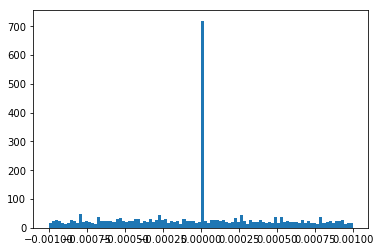

In [99]:
plt.hist((csv_y_pred['TX2'] - csv_y_pred['TX1'])[csv_y_pred['signal1'] == 0.], bins=100, range=(-1e-3, 1e-3));
plt.show()

In [96]:
first = train_0[:, 5]
second = train_0[:, 11]
np.sum(np.logical_and(first, second)) / np.sum(first)

0.77846915061099031

In [97]:
exp_f = np.copy(first)
exp_f[first == 1] = 0
exp_f[first == 0] = 1

exp_s = np.copy(second)
exp_s[second == 1] = 0
exp_s[second == 0] = 1
np.sum(np.logical_and(exp_f, exp_s)) / np.sum(exp_f)

0.9891467511865103

In [ ]:
back = pd.read_hdf('/data/viktor/data_4/hdf5-0/open10.h5')

#TX	TY	X	Y	Z	event_id	signal	data_ind
back = back.drop('event_id', axis=1)
back = back.drop('data_ind', axis=1)
back_array = np.array(back)
back_array_next = np.array([back_array[:, 0]*dZ + back_array[:, 2],
                            back_array[:, 1]*dZ + back_array[:, 3],
                            ((back_array[:, 4]//1293) + 1) * 1293]).T

start_time = time.time()

def my_function(i):
    global back_array
    global back_array_next
    neighbors = back_array[(back_array[:, 4] < back_array_next[i, 2] + 1200) & (back_array_next[i, 2] <= back_array[:, 4])]
    neighbors = neighbors[(neighbors[:, 2] < back_array_next[i, 0] + n) & (back_array_next[i, 0] - n < neighbors[:, 2])]
    neighbors = neighbors[(neighbors[:, 3] < back_array_next[i, 1] + n) & (back_array_next[i, 1] - n < neighbors[:, 3])]

    dist = np.sqrt((neighbors[:, 2] - back_array[i, 2]) ** 2 + (neighbors[:, 3] - back_array[i, 3]) ** 2 + (neighbors[:, 4] - back_array[i, 4]) ** 2)
    best_neighbors = neighbors[((abs(neighbors[:, 0] - back_array[i, 0]) + abs(neighbors[:, 1] - back_array[i, 1]) + 1e-3) / (1 + dist)).argsort()[:3]]
    if best_neighbors.shape[0] == 0:
        local_rows = []
        return
    if i%100000 == 0:
        print(i)
        print("--- %s seconds ---" % (time.time() - start_time))
    local_rows = []
    for neighbor in best_neighbors:
        local_rows.append(np.concatenate([back_array[i, :], neighbor]))
    return local_rows

        
        
sessions_train_1 = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in range(back.shape[0]))
sessions_train_1 = [x for x in sessions_train_1 if x is not None]
train_1 = np.concatenate(sessions_train_1)

0
--- 0.5719079971313477 seconds ---
10000
--- 26.497391939163208 seconds ---
20000
--- 51.73107719421387 seconds ---
30000
--- 77.04500436782837 seconds ---
40000
--- 103.65376448631287 seconds ---
60000
--- 155.4562647342682 seconds ---
70000
--- 181.2865858078003 seconds ---
80000
--- 206.37181544303894 seconds ---
90000
--- 232.83067297935486 seconds ---
100000
--- 259.93927526474 seconds ---
110000
--- 285.6162052154541 seconds ---
120000
--- 310.9941146373749 seconds ---


In [ ]:
back = pd.read_hdf('/data/viktor/data_4/hdf5-0/open100.h5')

#TX	TY	X	Y	Z	event_id	signal	data_ind
back = back.drop('event_id', axis=1)
back = back.drop('data_ind', axis=1)
back_array = np.array(back)
back_array_next = np.array([back_array[:, 0]*dZ + back_array[:, 2],
                            back_array[:, 1]*dZ + back_array[:, 3],
                            ((back_array[:, 4]//1293) + 1) * 1293]).T

start_time = time.time()

def my_function(i):
    global back_array
    global back_array_next
    neighbors = back_array[(back_array[:, 4] < back_array_next[i, 2] + 1200) & (back_array_next[i, 2] <= back_array[:, 4])]
    neighbors = neighbors[(neighbors[:, 2] < back_array_next[i, 0] + n) & (back_array_next[i, 0] - n < neighbors[:, 2])]
    neighbors = neighbors[(neighbors[:, 3] < back_array_next[i, 1] + n) & (back_array_next[i, 1] - n < neighbors[:, 3])]

    dist = np.sqrt((neighbors[:, 2] - back_array[i, 2]) ** 2 + (neighbors[:, 3] - back_array[i, 3]) ** 2 + (neighbors[:, 4] - back_array[i, 4]) ** 2)
    best_neighbors = neighbors[((abs(neighbors[:, 0] - back_array[i, 0]) + abs(neighbors[:, 1] - back_array[i, 1]) + 1e-3) / (1 + dist)).argsort()[:3]]
    if best_neighbors.shape[0] == 0:
        local_rows = []
        return
    if i%100000 == 0:
        print(i)
        print("--- %s seconds ---" % (time.time() - start_time))
    local_rows = []
    for neighbor in best_neighbors:
        local_rows.append(np.concatenate([back_array[i, :], neighbor]))
    return local_rows
        
        
sessions_train_2 = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in range(back.shape[0]))
sessions_train_2 = [x for x in sessions_train_2 if x is not None]
train_2 = np.concatenate(sessions_train_2)

In [ ]:
back = pd.read_hdf('/data/viktor/data_4/hdf5-0/open110.h5')

#TX	TY	X	Y	Z	event_id	signal	data_ind
back = back.drop('event_id', axis=1)
back = back.drop('data_ind', axis=1)
back_array = np.array(back)
back_array_next = np.array([back_array[:, 0]*dZ + back_array[:, 2],
                            back_array[:, 1]*dZ + back_array[:, 3],
                            ((back_array[:, 4]//1293) + 1) * 1293]).T

start_time = time.time()

def my_function(i):
    global back_array
    global back_array_next
    neighbors = back_array[(back_array[:, 4] < back_array_next[i, 2] + 1200) & (back_array_next[i, 2] <= back_array[:, 4])]
    neighbors = neighbors[(neighbors[:, 2] < back_array_next[i, 0] + n) & (back_array_next[i, 0] - n < neighbors[:, 2])]
    neighbors = neighbors[(neighbors[:, 3] < back_array_next[i, 1] + n) & (back_array_next[i, 1] - n < neighbors[:, 3])]

    dist = np.sqrt((neighbors[:, 2] - back_array[i, 2]) ** 2 + (neighbors[:, 3] - back_array[i, 3]) ** 2 + (neighbors[:, 4] - back_array[i, 4]) ** 2)
    best_neighbors = neighbors[((abs(neighbors[:, 0] - back_array[i, 0]) + abs(neighbors[:, 1] - back_array[i, 1]) + 1e-3) / (1 + dist)).argsort()[:3]]
    if best_neighbors.shape[0] == 0:
        local_rows = []
        return
    if i%100000 == 0:
        print(i)
        print("--- %s seconds ---" % (time.time() - start_time))
    local_rows = []
    for neighbor in best_neighbors:
        local_rows.append(np.concatenate([back_array[i, :], neighbor]))
    return local_rows

        
        
sessions_train_3 = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in range(back.shape[0]))
sessions_train_3 = [x for x in sessions_train_3 if x is not None]
train_3 = np.concatenate(sessions_train_3)

In [ ]:
back = pd.read_hdf('/data/viktor/data_4/hdf5-0/open120.h5')

#TX	TY	X	Y	Z	event_id	signal	data_ind
back = back.drop('event_id', axis=1)
back = back.drop('data_ind', axis=1)
back_array = np.array(back)
back_array_next = np.array([back_array[:, 0]*dZ + back_array[:, 2],
                            back_array[:, 1]*dZ + back_array[:, 3],
                            ((back_array[:, 4]//1293) + 1) * 1293]).T

start_time = time.time()

def my_function(i):
    global back_array
    global back_array_next
    neighbors = back_array[(back_array[:, 4] < back_array_next[i, 2] + 1200) & (back_array_next[i, 2] <= back_array[:, 4])]
    neighbors = neighbors[(neighbors[:, 2] < back_array_next[i, 0] + n) & (back_array_next[i, 0] - n < neighbors[:, 2])]
    neighbors = neighbors[(neighbors[:, 3] < back_array_next[i, 1] + n) & (back_array_next[i, 1] - n < neighbors[:, 3])]

    dist = np.sqrt((neighbors[:, 2] - back_array[i, 2]) ** 2 + (neighbors[:, 3] - back_array[i, 3]) ** 2 + (neighbors[:, 4] - back_array[i, 4]) ** 2)
    best_neighbors = neighbors[((abs(neighbors[:, 0] - back_array[i, 0]) + abs(neighbors[:, 1] - back_array[i, 1]) + 1e-3) / (1 + dist)).argsort()[:3]]
    if best_neighbors.shape[0] == 0:
        local_rows = []
        return
    if i%100000 == 0:
        print(i)
        print("--- %s seconds ---" % (time.time() - start_time))
    local_rows = []
    for neighbor in best_neighbors:
        local_rows.append(np.concatenate([back_array[i, :], neighbor]))
    return local_rows

        
        
sessions_train_4 = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in range(back.shape[0]))
sessions_train_4 = [x for x in sessions_train_4 if x is not None]
train_4 = np.concatenate(sessions_train_4)

In [ ]:
train_0 = np.vstack((train_0, train_1, train_2, train_3, train_4))
csv_y_pred = pd.DataFrame(data=train_0, columns=['TX1','TY1', 'X1', 'Y1','Z1', 'signal1', 'TX2','TY2', 'X2', 'Y2','Z2', 'signal2'])
csv_y_pred['dTX'] = csv_y_pred.TX1 - csv_y_pred.TX2
csv_y_pred['dTY'] = csv_y_pred.TY1 - csv_y_pred.TY2
csv_y_pred['dX'] = csv_y_pred.X1 - csv_y_pred.X2
csv_y_pred['dY'] = csv_y_pred.Y1 - csv_y_pred.Y2
csv_y_pred['dZ'] = csv_y_pred.Z1 - csv_y_pred.Z2

In [ ]:
csv_y_pred.to_csv('/data/viktor/data_4/hdf5-0/train.csv', index=False)

In [8]:
n = 300
dZ = 1293

In [ ]:
#TX	TY	X	Y	Z
n = 300
from joblib import Parallel, delayed
import time


global test_rows
global test_array
global test_array_next
test_rows = []
test = pd.read_hdf('/data/viktor/data_4/test_close10.h5')
test_0 = pd.read_hdf('/data/viktor/data_4/test_close0.h5')
frames = [test_0, test]
test = pd.concat(frames, ignore_index=True)
test = test.drop('data_ind', axis=1)
test['index'] = test.index
test_array = np.array(test)
test_array_next = np.array([test_array[:, 0]*dZ + test_array[:, 2],
                            test_array[:, 1]*dZ + test_array[:, 3],
                            ((test_array[:, 4]//1293) + 1) * 1293]).T

start_time = time.time()

def my_function(i):
    global test_rows
    global test_array
    global test_array_next
    neighbors = test_array[(test_array[:, 4] < test_array_next[i, 2] + 1200) & 
                           (test_array_next[i, 2] <= test_array[:, 4])]
    neighbors = neighbors[(neighbors[:, 2] < test_array_next[i, 0] + n) & 
                          (test_array_next[i, 0] - n < neighbors[:, 2])]
    neighbors = neighbors[(neighbors[:, 3] < test_array_next[i, 1] + n) & 
                          (test_array_next[i, 1] - n < neighbors[:, 3])]

    dist = np.sqrt((neighbors[:, 2] - test_array[i, 2]) ** 2 + (neighbors[:, 3] - test_array[i, 3]) ** 2 + (neighbors[:, 4] - test_array[i, 4]) ** 2)
    best_neighbors = neighbors[((abs(neighbors[:, 0] - test_array[i, 0]) + abs(neighbors[:, 1] - test_array[i, 1]) + 1e-3) / (1 + dist)).argsort()[:3]]
    if best_neighbors.shape[0] == 0:
        local_rows = []
        return
    if i%100000 == 0:
        print(i)
        print("--- %s seconds ---" % (time.time() - start_time))
    local_rows = []
    for neighbor in best_neighbors:
        local_rows.append(np.concatenate([test_array[i, :], neighbor]))
    return local_rows


        
        
sessions = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in range(test_array.shape[0])) #test_array.shape[0]


0
--- 0.7742631435394287 seconds ---


In [ ]:
ind_pred = []
zero_ind = []
test = []
for i in range(len(sessions)):
    if sessions[i] is not None:
        ind_pred.append(i)
        test.append(sessions[i])
    else:
        zero_ind.append(i)

In [ ]:
csv_y_pred_test = pd.DataFrame(data=ind_pred)
csv_y_pred_test.to_csv('/data/viktor/data_4/hdf5-0/ind_pred.csv', index=False)

csv_y_pred_test = pd.DataFrame(data=zero_ind)
csv_y_pred_test.to_csv('/data/viktor/data_4/hdf5-0/zero_ind.csv', index=False)

In [ ]:
test = np.concatenate(test)
csv_y_pred_test = pd.DataFrame(data=test, columns=['TX1','TY1', 'X1', 'Y1','Z1','index1', 'TX2','TY2', 'X2', 'Y2','Z2', 'index2'])
csv_y_pred_test['dTX'] = csv_y_pred_test.TX1 - csv_y_pred_test.TX2
csv_y_pred_test['dTY'] = csv_y_pred_test.TY1 - csv_y_pred_test.TY2
csv_y_pred_test['dX'] = csv_y_pred_test.X1 - csv_y_pred_test.X2
csv_y_pred_test['dY'] = csv_y_pred_test.Y1 - csv_y_pred_test.Y2
csv_y_pred_test['dZ'] = csv_y_pred_test.Z1 - csv_y_pred_test.Z2
csv_y_pred_test.to_csv('/data/viktor/data_4/hdf5-0/test.csv', index=False)

In [9]:
test_final = pd.read_csv('/data/viktor/data_4/hdf5-0/test.csv')
test_final = test_final.drop('index1', axis=1)
test_final = test_final.drop('index2', axis=1)
test_final = np.array(test_final)
# test_final = test[:, [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16]]

In [5]:
csv_y_pred = pd.read_csv('/data/viktor/data_4/hdf5-0/train.csv', nrows=10000000)
train = np.array(csv_y_pred)

In [6]:
csv_y_pred = pd.read_csv('/data/viktor/data_4/hdf5-0/trainCV.csv', nrows=1000000)
trainCV = np.array(csv_y_pred)
x_val = trainCV[:, [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16]]
# y_val = trainCV[:, 5]
y_val = np.logical_and(trainCV[:, 5], trainCV[:, 11])

In [70]:
del csv_y_pred, trainCV
# del test, test_0, test_array, test_array_next, test_rows

In [23]:
from xgboost import XGBClassifier

target_train = np.logical_and(train[:, 5], train[:, 11])

model = XGBClassifier(n_jobs=-1,n_estimators=500, n_samples=2500, n_features=45, n_informative=5, n_redundant=25)
model.fit(train[:, [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16]], target_train, eval_set=[(x_val, y_val)], 
          eval_metric="auc", early_stopping_rounds=30, verbose=True)

[0]	validation_0-auc:0.717847
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.75441
[2]	validation_0-auc:0.803601
[3]	validation_0-auc:0.813912
[4]	validation_0-auc:0.82853
[5]	validation_0-auc:0.825525
[6]	validation_0-auc:0.810435
[7]	validation_0-auc:0.799984
[8]	validation_0-auc:0.82179
[9]	validation_0-auc:0.822441
[10]	validation_0-auc:0.82688
[11]	validation_0-auc:0.817589
[12]	validation_0-auc:0.818879
[13]	validation_0-auc:0.825499
[14]	validation_0-auc:0.831091
[15]	validation_0-auc:0.826654
[16]	validation_0-auc:0.823146
[17]	validation_0-auc:0.829582
[18]	validation_0-auc:0.83424
[19]	validation_0-auc:0.832413
[20]	validation_0-auc:0.833199
[21]	validation_0-auc:0.830786
[22]	validation_0-auc:0.832537
[23]	validation_0-auc:0.837472
[24]	validation_0-auc:0.838902
[25]	validation_0-auc:0.836367
[26]	validation_0-auc:0.841507
[27]	validation_0-auc:0.840821
[28]	validation_0-auc:0.842669
[29]	validation_0-auc:0.84797
[30]	validation_0-auc:

[259]	validation_0-auc:0.913411
[260]	validation_0-auc:0.913595
[261]	validation_0-auc:0.913931
[262]	validation_0-auc:0.913316
[263]	validation_0-auc:0.913462
[264]	validation_0-auc:0.91363
[265]	validation_0-auc:0.913742
[266]	validation_0-auc:0.913803
[267]	validation_0-auc:0.913519
[268]	validation_0-auc:0.913595
[269]	validation_0-auc:0.913175
[270]	validation_0-auc:0.913465
[271]	validation_0-auc:0.913193
[272]	validation_0-auc:0.913343
[273]	validation_0-auc:0.913462
[274]	validation_0-auc:0.91399
[275]	validation_0-auc:0.914234
[276]	validation_0-auc:0.91428
[277]	validation_0-auc:0.914208
[278]	validation_0-auc:0.914447
[279]	validation_0-auc:0.914562
[280]	validation_0-auc:0.914877
[281]	validation_0-auc:0.914919
[282]	validation_0-auc:0.914977
Stopping. Best iteration:
[252]	validation_0-auc:0.915524



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_features=45, n_informative=5, n_jobs=-1, n_redundant=25,
       n_samples=2500, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [32]:
model.best_score

0.917779

In [33]:
predicted = model.predict_proba(test_final)

In [14]:
count = []
i = 0
while  i  < test_final.shape[0] - 1:
    if i == test_final.shape[0] - 1:
        break
    c = 1
    while np.all(np.equal(test_final[i, [0, 1, 2, 3, 4]], test_final[i + 1, [0, 1, 2, 3, 4]])):
        i += 1
        c += 1
        if i == test_final.shape[0] - 1:
            break
    count.append(c)
    i += 1

In [15]:
count_array = np.array(count)

In [34]:
j = 0
predicted_ready = np.zeros(count_array.shape[0])
for i in range(count_array.shape[0]):
    k = count_array[i]
    try:
        predicted_ready[i] = np.max(predicted[j:j + k,1])
    except:
        print(j, k, j+k)
        break
    j += k

In [21]:
ind_pred = pd.read_csv('/data/viktor/data_4/hdf5-0/ind_pred.csv')
indices_zero = pd.read_csv('/data/viktor/data_4/hdf5-0/zero_ind.csv')

In [35]:
# ind_pred = pd.DataFrame(ind_pred)
# indices_zero = pd.DataFrame(zero_ind)

csv_y_pred = pd.DataFrame(data=predicted_ready[:-1])
csv_y_pred = pd.concat([ind_pred, csv_y_pred], axis=1)

csv_y_pred_zero = pd.DataFrame(data=np.zeros(len(indices_zero)))
csv_y_pred_zero = pd.concat([indices_zero, csv_y_pred_zero], axis=1)

frames = [csv_y_pred, csv_y_pred_zero]
csv_y_pred = pd.concat(frames, ignore_index=True)
csv_y_pred.columns = ['id', 'signal']

csv_y_pred = csv_y_pred.sort_values("id")
csv_y_pred.signal[7542117] = 0

csv_y_pred.to_csv('/data/viktor/data_4/hdf5-0/answers_pair.csv', index=False)

/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [ ]:
n = 300

back = pd.read_hdf('/data/viktor/data_4/hdf5-0/open130.h5')

#TX	TY	X	Y	Z	event_id	signal	data_ind
back = back.drop('event_id', axis=1)
back = back.drop('data_ind', axis=1)
back_array = np.array(back)
back_array_next = np.array([back_array[:, 0]*dZ + back_array[:, 2],
                            back_array[:, 1]*dZ + back_array[:, 3],
                            ((back_array[:, 4]//1293) + 1) * 1293]).T

start_time = time.time()

def my_function(i):
    global back_array
    global back_array_next
    neighbors = back_array[(back_array[:, 4] < back_array_next[i, 2] + 1200) & (back_array_next[i, 2] <= back_array[:, 4])]
    neighbors = neighbors[(neighbors[:, 2] < back_array_next[i, 0] + n) & (back_array_next[i, 0] - n < neighbors[:, 2])]
    neighbors = neighbors[(neighbors[:, 3] < back_array_next[i, 1] + n) & (back_array_next[i, 1] - n < neighbors[:, 3])]

    dist = np.sqrt((neighbors[:, 2] - back_array[i, 2]) ** 2 + (neighbors[:, 3] - back_array[i, 3]) ** 2 + (neighbors[:, 4] - back_array[i, 4]) ** 2)
    best_neighbors = neighbors[((abs(neighbors[:, 0] - back_array[i, 0]) + abs(neighbors[:, 1] - back_array[i, 1]) + 1e-3) / (1 + dist)).argsort()[:3]]
    if best_neighbors.shape[0] == 0:
        local_rows = []
        return
    if i%100000 == 0:
        print(i)
        print("--- %s seconds ---" % (time.time() - start_time))
    local_rows = []
    for neighbor in best_neighbors:
        local_rows.append(np.concatenate([back_array[i, :], neighbor]))
    return local_rows

        
        
sessions_trainCV_0 = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in range(back.shape[0]))
sessions_trainCV_0 = [x for x in sessions_trainCV_0 if x is not None]
trainCV_0 = np.concatenate(sessions_trainCV_0)

0
--- 0.4155855178833008 seconds ---


In [ ]:
n = 300

back = pd.read_hdf('/data/viktor/data_4/hdf5-0/open140.h5')

#TX	TY	X	Y	Z	event_id	signal	data_ind
back = back.drop('event_id', axis=1)
back = back.drop('data_ind', axis=1)
back_array = np.array(back)
back_array_next = np.array([back_array[:, 0]*dZ + back_array[:, 2],
                            back_array[:, 1]*dZ + back_array[:, 3],
                            ((back_array[:, 4]//1293) + 1) * 1293]).T

start_time = time.time()

def my_function(i):
    global back_array
    global back_array_next
    neighbors = back_array[(back_array[:, 4] < back_array_next[i, 2] + 1200) & (back_array_next[i, 2] <= back_array[:, 4])]
    neighbors = neighbors[(neighbors[:, 2] < back_array_next[i, 0] + n) & (back_array_next[i, 0] - n < neighbors[:, 2])]
    neighbors = neighbors[(neighbors[:, 3] < back_array_next[i, 1] + n) & (back_array_next[i, 1] - n < neighbors[:, 3])]

    dist = np.sqrt((neighbors[:, 2] - back_array[i, 2]) ** 2 + (neighbors[:, 3] - back_array[i, 3]) ** 2 + (neighbors[:, 4] - back_array[i, 4]) ** 2)
    best_neighbors = neighbors[((abs(neighbors[:, 0] - back_array[i, 0]) + abs(neighbors[:, 1] - back_array[i, 1]) + 1e-3) / (1 + dist)).argsort()[:3]]
    if best_neighbors.shape[0] == 0:
        local_rows = []
        return
    if i%100000 == 0:
        print(i)
        print("--- %s seconds ---" % (time.time() - start_time))
    local_rows = []
    for neighbor in best_neighbors:
        local_rows.append(np.concatenate([back_array[i, :], neighbor]))
    return local_rows

        
        
sessions_trainCV_1 = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in range(back.shape[0]))
sessions_trainCV_1 = [x for x in sessions_trainCV_1 if x is not None]
trainCV_1 = np.concatenate(sessions_trainCV_1)

In [ ]:
train_0 = np.vstack((trainCV_0, trainCV_1))
csv_CV = pd.DataFrame(data=train_0, columns=['TX1','TY1', 'X1', 'Y1','Z1', 'signal1', 'TX2','TY2', 'X2', 'Y2','Z2', 'signal2'])
csv_CV['dTX'] = csv_CV.TX1 - csv_CV.TX2
csv_CV['dTY'] = csv_CV.TY1 - csv_CV.TY2
csv_CV['dX'] = csv_CV.X1 - csv_CV.X2
csv_CV['dY'] = csv_CV.Y1 - csv_CV.Y2
csv_CV['dZ'] = csv_CV.Z1 - csv_CV.Z2
csv_CV.to_csv('/data/viktor/data_4/hdf5-0/trainCV.csv', index=False)